<a href="https://colab.research.google.com/github/fatememvi/CHEST_XRAY_PNUMONIA_COVID_CLASSIFICATION/blob/main/XRay_CNN_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms , datasets
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import numpy as np




torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


**Load Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
data_dir = "/content/drive/MyDrive/archive_14.zip"

extract_path = "/content/PadChest_dataset"

In [5]:
import zipfile

with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")

✅ Dataset extracted successfully!


**Total Images in Dataset**

In [47]:
import pandas as pd


data_dir = "/content/PadChest_dataset"
categories = ["COVID", "PNEUMONIA", "NORMAL"]

data = []
for label, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(path, img_name)
            data.append([img_path, label])

df = pd.DataFrame(data, columns=["image", "label"])
print(df.head())
print(f"Total images: {len(df)}")



                                            image  label
0  /content/PadChest_dataset/COVID/COVID_1303.png      0
1  /content/PadChest_dataset/COVID/COVID_1200.png      0
2   /content/PadChest_dataset/COVID/COVID_722.png      0
3   /content/PadChest_dataset/COVID/COVID_776.png      0
4   /content/PadChest_dataset/COVID/COVID_886.png      0
Total images: 5228


**Plot Bar Graph**

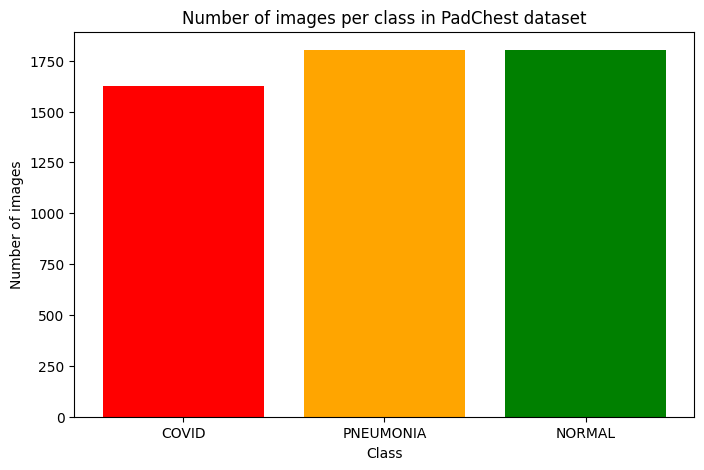

In [7]:
data_dir = "/content/PadChest_dataset"
categories = ["COVID", "PNEUMONIA", "NORMAL"]

counts = []
for category in categories:
    path = os.path.join(data_dir, category)
    count = len([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    counts.append(count)

plt.figure(figsize=(8,5))
plt.bar(categories, counts, color=['red','orange','green'])
plt.title("Number of images per class in PadChest dataset")
plt.ylabel("Number of images")
plt.xlabel("Class")
plt.show()

**Display the Images**

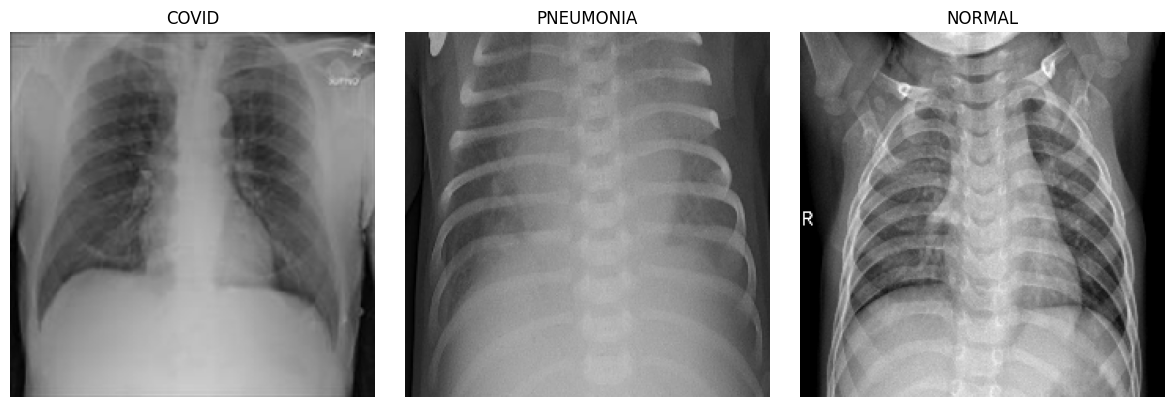

In [8]:
data_dir = "/content/PadChest_dataset"
categories = ["COVID", "PNEUMONIA", "NORMAL"]

plt.figure(figsize=(12,4))

for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    images = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    img_name = random.choice(images)
    img_path = os.path.join(path, img_name)

    img = Image.open(img_path)

    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Transforms**

In [9]:
from PIL import ImageFilter

class RandomNoise(object):

    def __call__(self, img):
        arr = np.array(img).astype(np.float32) / 255.0
        noise = np.random.normal(0, 0.02, arr.shape)
        arr = np.clip(arr + noise, 0, 1)
        arr = (arr * 255).astype(np.uint8)
        return transforms.functional.to_pil_image(arr)

class RandomContrastBrightness(object):

    def __call__(self, img):
        factor = random.uniform(0.9, 1.1)  # contrast
        img = transforms.functional.adjust_contrast(img, factor)
        factor = random.uniform(0.9, 1.1)  # brightness
        img = transforms.functional.adjust_brightness(img, factor)
        return img

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05), shear=5),
    RandomContrastBrightness(),
    RandomNoise(),
    transforms.GaussianBlur(kernel_size=(3,5), sigma=(0.1,1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



**Create Train Object**

In [10]:
from torch.utils.data import DataLoader, random_split, Subset



dataset = datasets.ImageFolder(root=extract_path, transform=train_transform)
class_to_idx = dataset.class_to_idx
print("Class mapping:", class_to_idx)

labels = np.array([label for _, label in dataset.imgs])
num_samples = len(dataset)
train_ratio = 0.8
val_ratio = 0.2


train_indices = []
val_indices = []

for cls in np.unique(labels):
    cls_indices = np.where(labels == cls)[0]
    np.random.shuffle(cls_indices)
    split = int(len(cls_indices) * train_ratio)
    train_indices.extend(cls_indices[:split])
    val_indices.extend(cls_indices[split:])


train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")



Class mapping: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Train dataset size: 4181
Validation dataset size: 1047


**Plot the Images**

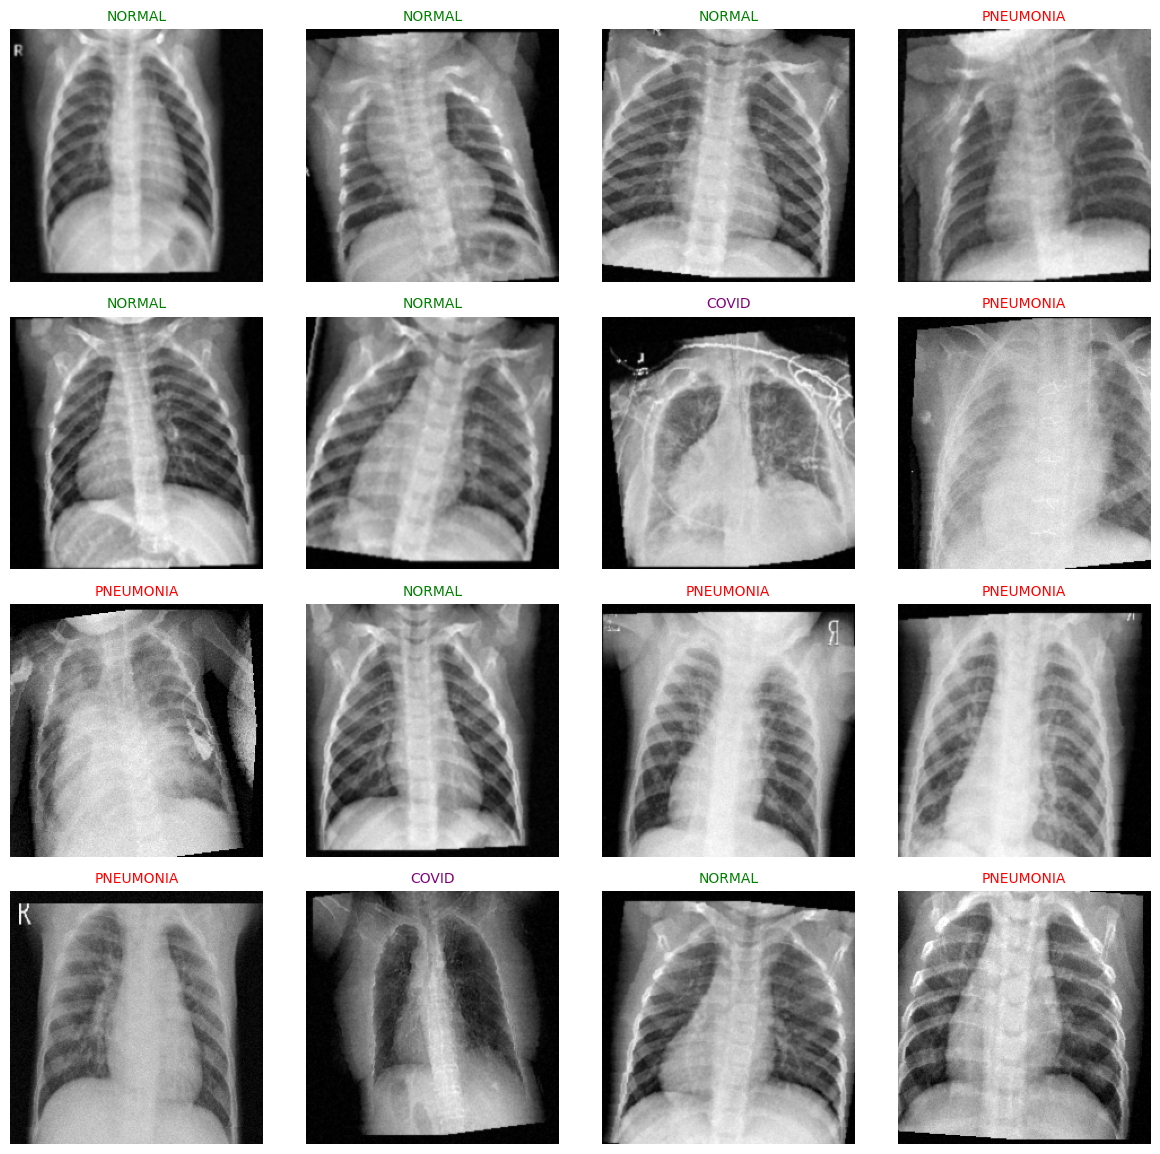

In [15]:
import matplotlib.pyplot as plt



indices = random.sample(range(len(train_dataset)), 16)
samples = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]


class_names = {0: 'COVID', 1: 'NORMAL', 2: 'PNEUMONIA'}


fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.ravel()):
    img = samples[i].permute(1, 2, 0).numpy()
    ax.imshow(img.squeeze(), cmap='gray')
    label_idx = labels[i]
    ax.set_title(f"{class_names[label_idx]}", color='green' if label_idx==1 else ('red' if label_idx==2 else 'purple'), fontsize=10)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


**Validation Loop**

In [31]:
for val_data, val_labels in tqdm(val_dataset, desc="Validating", colour="magenta"):
    val_data = val_data.to(device)
    val_labels = torch.tensor(val_labels, dtype=torch.long, device=device)  # ✅ fixed


Validating: 100%|██████████| 1047/1047 [00:07<00:00, 135.78it/s]


**CNN Model**

In [32]:


class XRayCNN(nn.Module):
    """
    Custom CNN for Pediatric Chest X-ray Classification
    Classes: COVID, NORMAL, PNEUMONIA
    """

    def __init__(self, num_classes=3):
        super(XRayCNN, self).__init__()

        # --- Feature Extraction Layers ---
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # 224 -> 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 224 -> 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 112 -> 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(2),                              # 112 -> 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 56 -> 56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),                              # 56 -> 28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),# 28 -> 28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),                              # 28 -> 14
        )

        # --- Classifier Layers ---
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x  # raw logits (no softmax here)

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XRayCNN().to(device)
print(model)



XRayCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Ba

**CNN summary report**

In [33]:
from torchsummary import summary
summary(model, (1,224,224)) # (C,H,W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
           Dropout-8         [-1, 64, 112, 112]               0
         MaxPool2d-9           [-1, 64, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]          73,856
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
          Dropout-13          [-1, 128, 56, 56]               0
        MaxPool2d-14          [-1, 128,

**Define Optimizers**

In [34]:
criterian = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 30

In [35]:
for data, labels in tqdm(train_dataset, desc=f"Training Epoch {epoch+1}", colour="cyan"):
    data = data.to(device)
    labels = torch.tensor(labels, dtype=torch.long, device=device)  # ✅ fixed


Training Epoch 1: 100%|██████████| 4181/4181 [00:30<00:00, 137.76it/s]


**Define Model Training**

In [37]:
from tqdm import tqdm
import datetime


# 📦 Initialize tracking lists
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# 🚀 Best validation tracker
best_val_loss = float('inf')

# 🗂️ Directory for model checkpoints (auto timestamp)
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = f"checkpoints_{timestamp}"
os.makedirs(checkpoint_dir, exist_ok=True)

# 📉 Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

print(f"🔧 Training started for {epochs} epochs on device: {device}\n")

for epoch in range(epochs):
    print(f"📘 Epoch {epoch+1}/{epochs}")
    model.train()
    correct, train_running_loss = 0, 0.0

    # 🔄 TRAIN LOOP
    for data, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", colour="cyan"):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterian(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_train_loss = train_running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / len(train_dataset)

    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_acc)

    # 📊 VALIDATION LOOP
    model.eval()
    val_correct, val_running_loss = 0, 0.0
    with torch.no_grad():
        for val_data, val_labels in tqdm(val_loader, desc="Validating", colour="magenta"):
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            val_outputs = model(val_data)
            val_loss_value = criterian(val_outputs, val_labels)

            val_running_loss += val_loss_value.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_acc = 100 * val_correct / len(val_dataset)

    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_acc)

    # 🧠 Report
    print(f"🔹 Training Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.2f}%")
    print(f"🔸 Validation Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.2f}%")

    # 💾 Save the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved at {best_model_path} (Val Loss: {best_val_loss:.4f})")

    # 🔄 Scheduler step
    scheduler.step()
    print(f"📉 LR updated to: {scheduler.get_last_lr()[0]:.6f}\n")

print("\n🎯 Training complete!")
print(f"Best Validation Loss: {best_val_loss:.4f}")

🔧 Training started for 30 epochs on device: cuda

📘 Epoch 1/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.75it/s]


🔹 Training Loss: 0.4468 | Acc: 84.86%
🔸 Validation Loss: 0.6762 | Acc: 69.72%
✅ Best model saved at checkpoints_20251101-144745/best_model.pth (Val Loss: 0.6762)
📉 LR updated to: 0.000100

📘 Epoch 2/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.52it/s]


🔹 Training Loss: 0.3117 | Acc: 90.05%
🔸 Validation Loss: 0.7688 | Acc: 67.14%
📉 LR updated to: 0.000099

📘 Epoch 3/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.48it/s]


🔹 Training Loss: 0.2681 | Acc: 91.27%
🔸 Validation Loss: 0.7253 | Acc: 70.01%
📉 LR updated to: 0.000098

📘 Epoch 4/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]


🔹 Training Loss: 0.2366 | Acc: 92.13%
🔸 Validation Loss: 0.5969 | Acc: 74.12%
✅ Best model saved at checkpoints_20251101-144745/best_model.pth (Val Loss: 0.5969)
📉 LR updated to: 0.000096

📘 Epoch 5/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.35it/s]


🔹 Training Loss: 0.2179 | Acc: 92.94%
🔸 Validation Loss: 0.6590 | Acc: 71.54%
📉 LR updated to: 0.000093

📘 Epoch 6/30


Validating: 100%|██████████| 33/33 [00:06<00:00,  5.45it/s]


🔹 Training Loss: 0.2010 | Acc: 93.59%
🔸 Validation Loss: 0.6641 | Acc: 72.21%
📉 LR updated to: 0.000090

📘 Epoch 7/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.64it/s]


🔹 Training Loss: 0.2029 | Acc: 93.59%
🔸 Validation Loss: 0.4275 | Acc: 83.48%
✅ Best model saved at checkpoints_20251101-144745/best_model.pth (Val Loss: 0.4275)
📉 LR updated to: 0.000087

📘 Epoch 8/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.51it/s]


🔹 Training Loss: 0.1869 | Acc: 94.07%
🔸 Validation Loss: 0.4715 | Acc: 79.66%
📉 LR updated to: 0.000083

📘 Epoch 9/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


🔹 Training Loss: 0.1825 | Acc: 93.73%
🔸 Validation Loss: 0.4442 | Acc: 82.71%
📉 LR updated to: 0.000079

📘 Epoch 10/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.66it/s]


🔹 Training Loss: 0.1878 | Acc: 93.81%
🔸 Validation Loss: 0.4415 | Acc: 82.81%
📉 LR updated to: 0.000075

📘 Epoch 11/30


Validating: 100%|██████████| 33/33 [00:06<00:00,  5.01it/s]


🔹 Training Loss: 0.1645 | Acc: 94.14%
🔸 Validation Loss: 0.5302 | Acc: 78.51%
📉 LR updated to: 0.000070

📘 Epoch 12/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.81it/s]


🔹 Training Loss: 0.1532 | Acc: 94.95%
🔸 Validation Loss: 0.4125 | Acc: 83.48%
✅ Best model saved at checkpoints_20251101-144745/best_model.pth (Val Loss: 0.4125)
📉 LR updated to: 0.000065

📘 Epoch 13/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.38it/s]


🔹 Training Loss: 0.1549 | Acc: 94.64%
🔸 Validation Loss: 0.5310 | Acc: 79.56%
📉 LR updated to: 0.000060

📘 Epoch 14/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.62it/s]


🔹 Training Loss: 0.1606 | Acc: 94.52%
🔸 Validation Loss: 0.2874 | Acc: 88.92%
✅ Best model saved at checkpoints_20251101-144745/best_model.pth (Val Loss: 0.2874)
📉 LR updated to: 0.000055

📘 Epoch 15/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.41it/s]


🔹 Training Loss: 0.1425 | Acc: 95.65%
🔸 Validation Loss: 0.4012 | Acc: 83.76%
📉 LR updated to: 0.000050

📘 Epoch 16/30


Validating: 100%|██████████| 33/33 [00:06<00:00,  5.47it/s]


🔹 Training Loss: 0.1495 | Acc: 94.95%
🔸 Validation Loss: 0.4406 | Acc: 82.43%
📉 LR updated to: 0.000045

📘 Epoch 17/30


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.91it/s]


🔹 Training Loss: 0.1365 | Acc: 95.60%
🔸 Validation Loss: 0.3330 | Acc: 87.39%
📉 LR updated to: 0.000040

📘 Epoch 18/30


Validating: 100%|██████████| 33/33 [00:06<00:00,  5.45it/s]


🔹 Training Loss: 0.1284 | Acc: 95.77%
🔸 Validation Loss: 0.4157 | Acc: 83.38%
📉 LR updated to: 0.000035

📘 Epoch 19/30


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.83it/s]


🔹 Training Loss: 0.1314 | Acc: 95.48%
🔸 Validation Loss: 0.3641 | Acc: 85.00%
📉 LR updated to: 0.000030

📘 Epoch 20/30


Validating: 100%|██████████| 33/33 [00:06<00:00,  5.15it/s]


🔹 Training Loss: 0.1238 | Acc: 95.98%
🔸 Validation Loss: 0.3889 | Acc: 84.91%
📉 LR updated to: 0.000025

📘 Epoch 21/30


Validating: 100%|██████████| 33/33 [00:06<00:00,  5.33it/s]


🔹 Training Loss: 0.1256 | Acc: 95.93%
🔸 Validation Loss: 0.5689 | Acc: 77.65%
📉 LR updated to: 0.000021

📘 Epoch 22/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.54it/s]


🔹 Training Loss: 0.1148 | Acc: 96.15%
🔸 Validation Loss: 0.4319 | Acc: 82.23%
📉 LR updated to: 0.000017

📘 Epoch 23/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.60it/s]


🔹 Training Loss: 0.1127 | Acc: 96.56%
🔸 Validation Loss: 0.3785 | Acc: 84.34%
📉 LR updated to: 0.000013

📘 Epoch 24/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.41it/s]


🔹 Training Loss: 0.1184 | Acc: 96.15%
🔸 Validation Loss: 0.3444 | Acc: 86.82%
📉 LR updated to: 0.000010

📘 Epoch 25/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.65it/s]


🔹 Training Loss: 0.1128 | Acc: 96.13%
🔸 Validation Loss: 0.3553 | Acc: 85.86%
📉 LR updated to: 0.000007

📘 Epoch 26/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.40it/s]


🔹 Training Loss: 0.1167 | Acc: 96.01%
🔸 Validation Loss: 0.4147 | Acc: 83.38%
📉 LR updated to: 0.000004

📘 Epoch 27/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.63it/s]


🔹 Training Loss: 0.1078 | Acc: 96.68%
🔸 Validation Loss: 0.3541 | Acc: 86.72%
📉 LR updated to: 0.000002

📘 Epoch 28/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.39it/s]


🔹 Training Loss: 0.1125 | Acc: 96.13%
🔸 Validation Loss: 0.3831 | Acc: 84.72%
📉 LR updated to: 0.000001

📘 Epoch 29/30


Validating: 100%|██████████| 33/33 [00:05<00:00,  5.60it/s]


🔹 Training Loss: 0.1095 | Acc: 96.29%
🔸 Validation Loss: 0.4799 | Acc: 81.28%
📉 LR updated to: 0.000000

📘 Epoch 30/30


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.46it/s]

🔹 Training Loss: 0.1008 | Acc: 96.77%
🔸 Validation Loss: 0.3279 | Acc: 87.49%
📉 LR updated to: 0.000000


🎯 Training complete!
Best Validation Loss: 0.2874


**Plot Accuracy and Loss graph**

/tmp/ipython-input-2538061766.py:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipython-input-2538061766.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


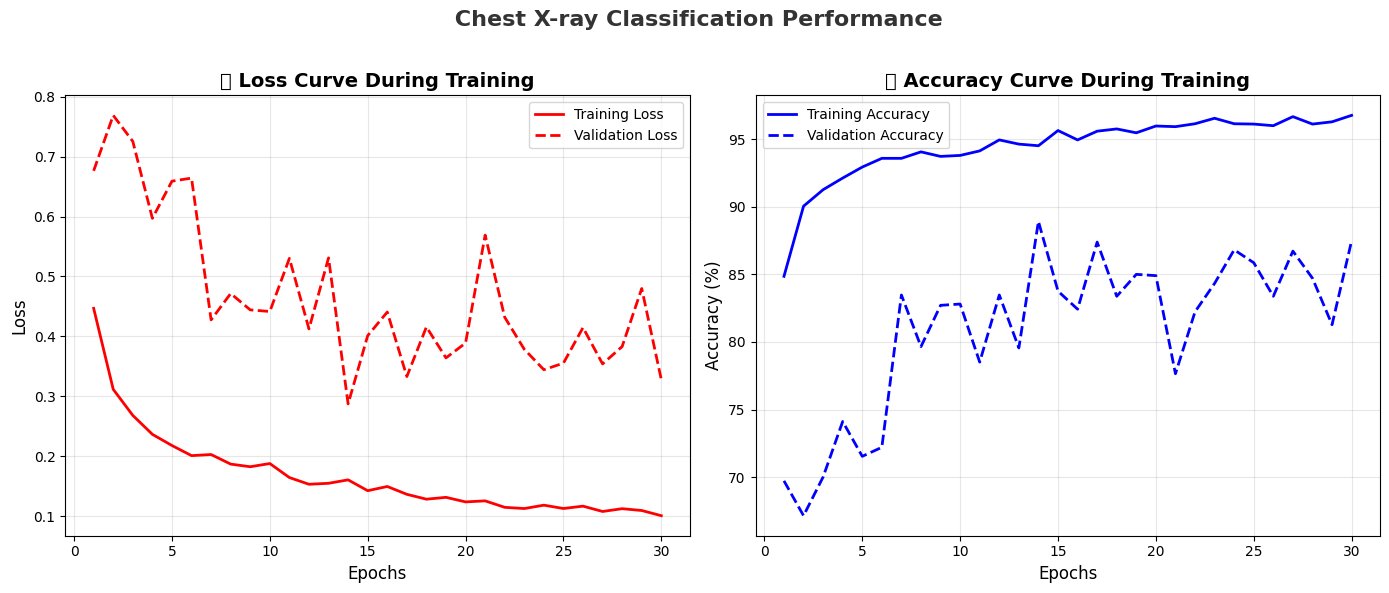

In [38]:
# 📊 Training & Validation Loss and Accuracy Visualization

epoch_log = list(range(1, epochs + 1))

plt.figure(figsize=(14, 6))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1)
plt.plot(epoch_log, train_loss, 'r-', linewidth=2, label='Training Loss')
plt.plot(epoch_log, val_loss, 'r--', linewidth=2, label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('📉 Loss Curve During Training', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# --- Plot 2: Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epoch_log, train_accuracy, 'b-', linewidth=2, label='Training Accuracy')
plt.plot(epoch_log, val_accuracy, 'b--', linewidth=2, label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('📈 Accuracy Curve During Training', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle(' Chest X-ray Classification Performance', fontsize=16, fontweight='bold', color='#333')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Load the Model**

In [43]:
!find /content -name "best_model.pth"


/content/checkpoints_20251101-144745/best_model.pth


In [45]:
checkpoint_path = "/content/checkpoints_20251101-144745/best_model.pth"
model = XRayCNN().to(device)

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    print("✅ Model loaded successfully from:", checkpoint_path)
else:
    print("⚠️ Warning: No trained model found at", checkpoint_path)


✅ Model loaded successfully from: /content/checkpoints_20251101-144745/best_model.pth


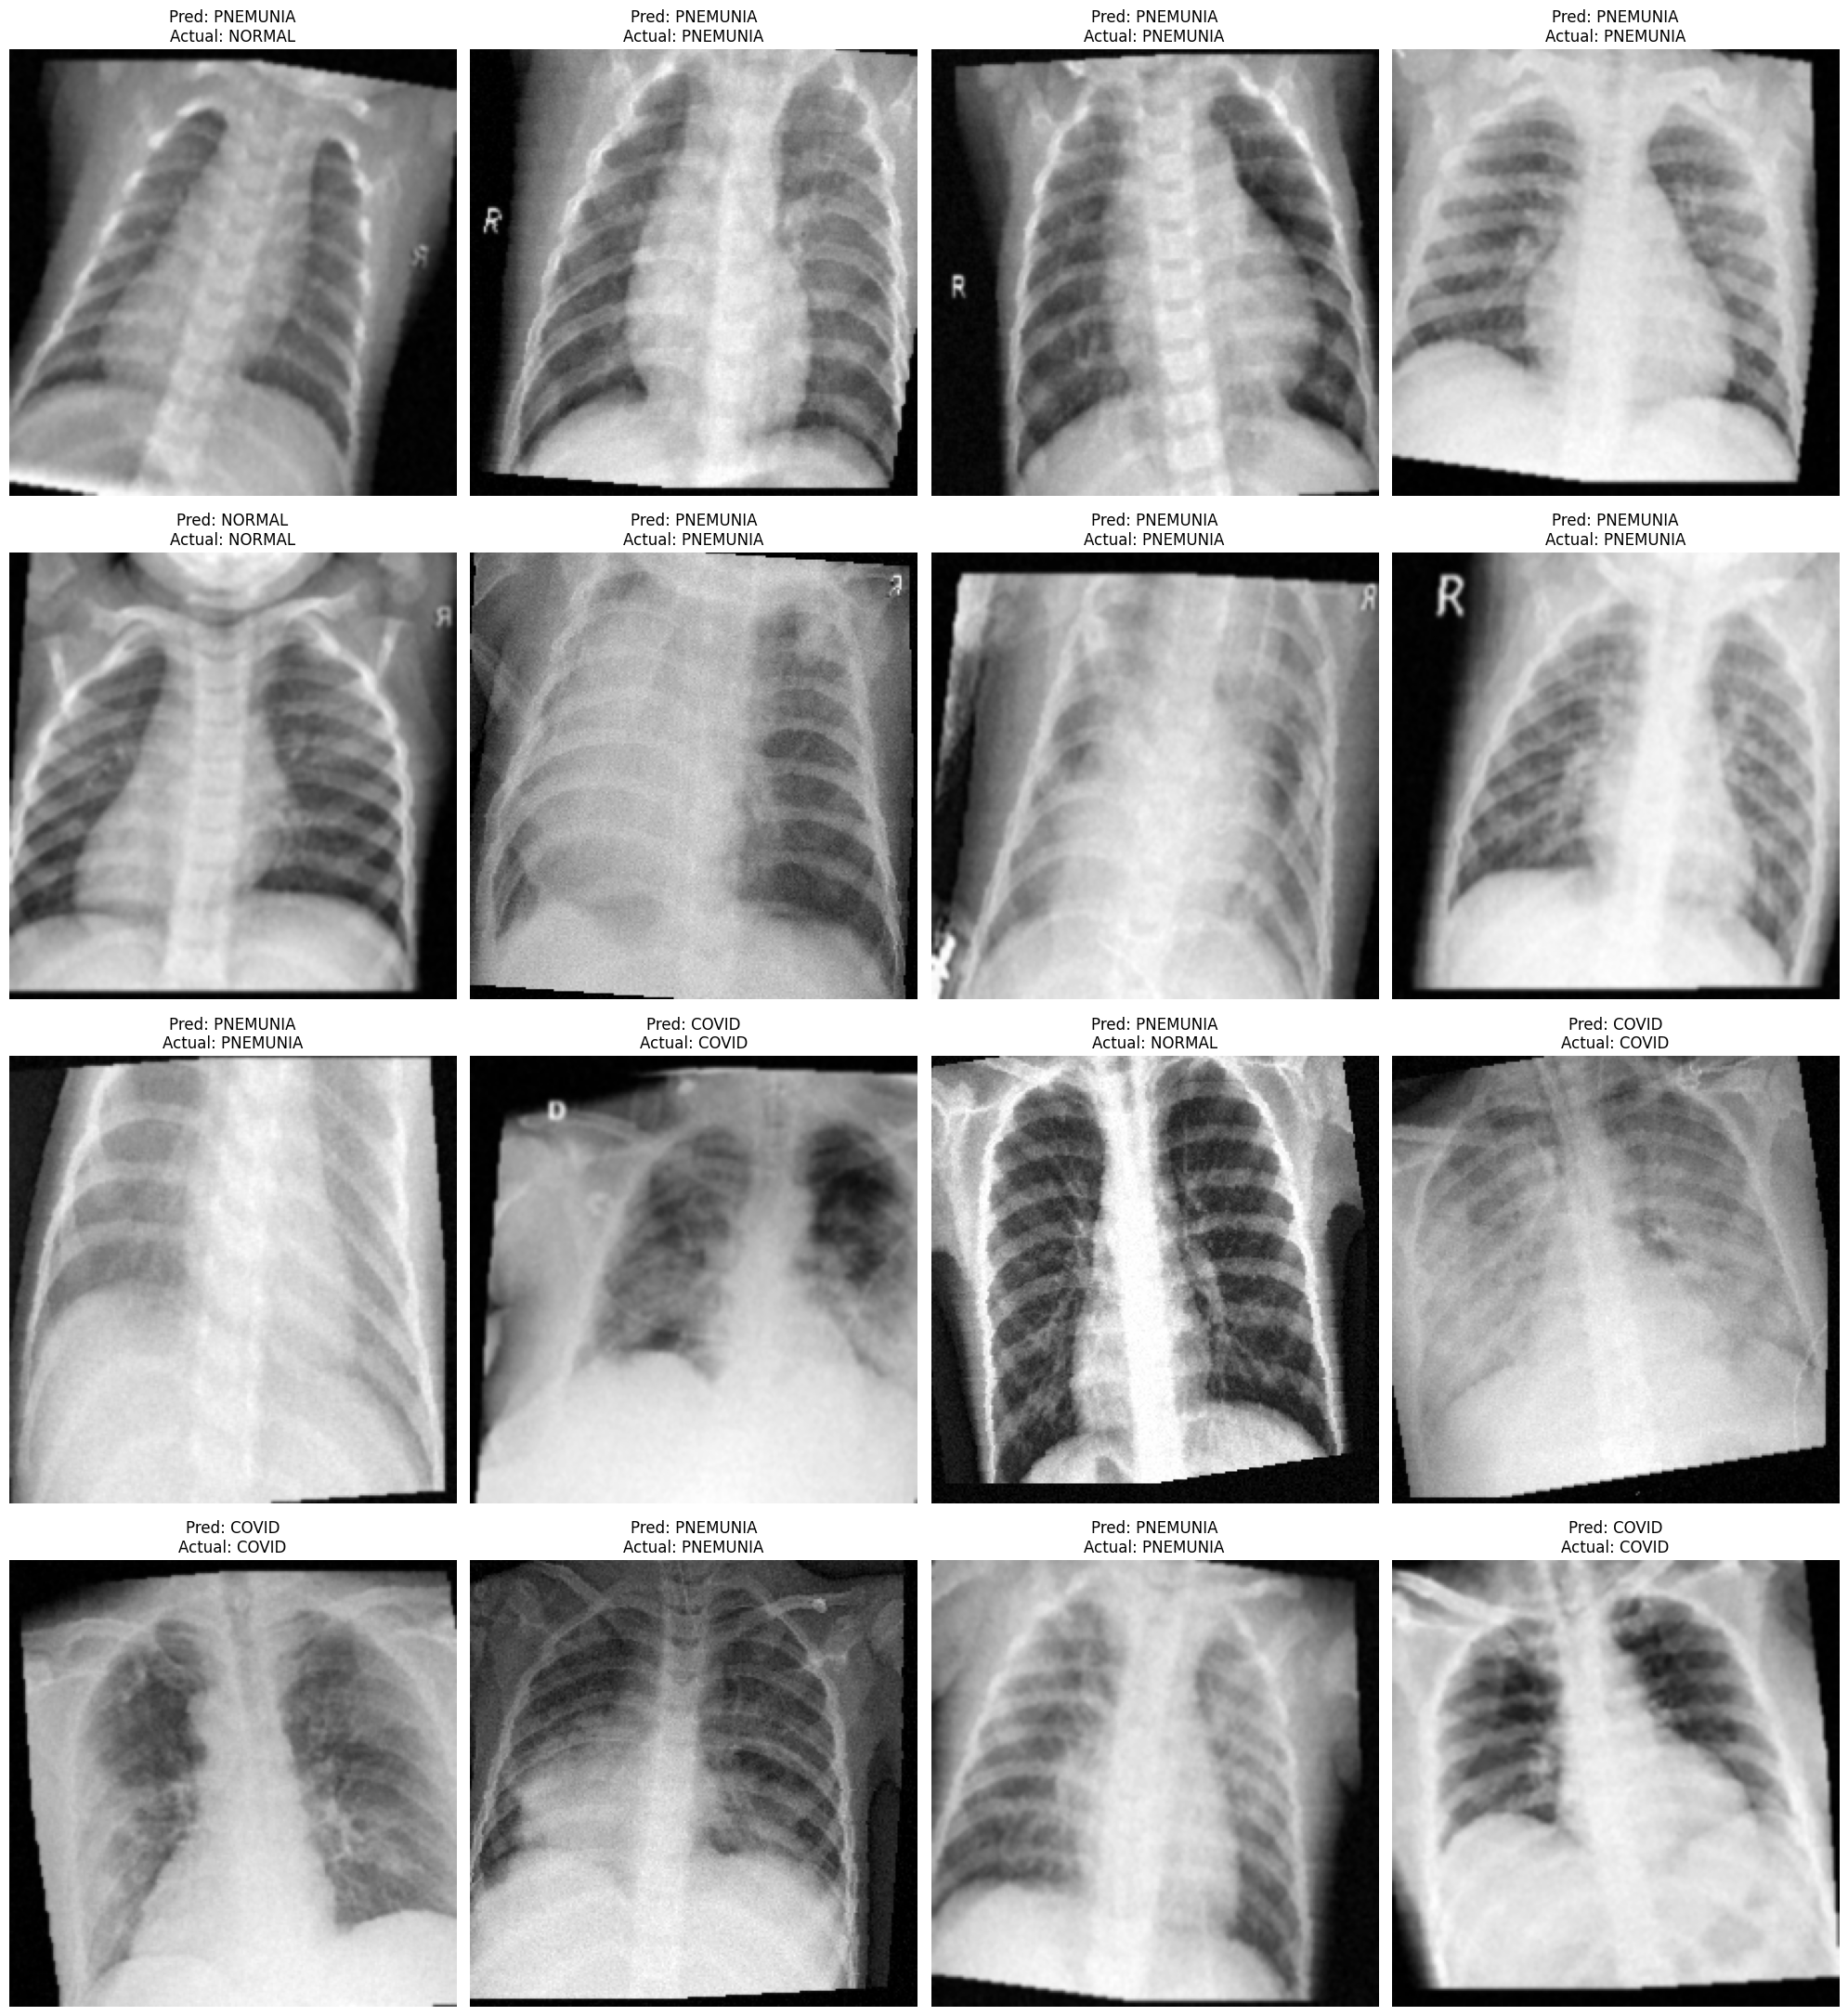

In [46]:



# 📌 Use validation dataset as test if separate test folder doesn't exist
test_dataset = val_dataset  # val_dataset previously defined
class_names = {0: 'COVID', 1: 'NORMAL', 2: 'PNEMUNIA' }

# 🖼️ Prepare figure
fig, axes = plt.subplots(4, 4, figsize=(20, 22))
axes = axes.ravel()

# 🔄 Randomly sample 16 images from validation dataset
indices = random.sample(range(len(test_dataset)), 16)

for i, idx in enumerate(indices):
    # Get image tensor and label
    img_tensor, true_label = test_dataset[idx]

    # Preprocess image
    img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make prediction
    output = model(img_tensor)
    pred_label = torch.argmax(output, dim=1).item()

    # Convert tensor to image for plotting
    img_np = img_tensor.squeeze().cpu().numpy()

    # Plot
    axes[i].imshow(img_np, cmap='gray')
    axes[i].set_title(f'Pred: {class_names[pred_label]}\nActual: {class_names[true_label]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
